# Flux with MNIST


## Libraries

In [2]:
using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [3]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

,,,,

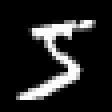
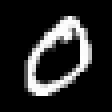
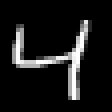
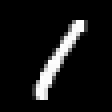
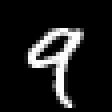

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [6]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [7]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### Model

In [62]:
# data on gpu
X_d = X |> gpu
y_d = y |> gpu;


In [63]:
# model configuration
nInputs  = d
nOutputs = 10
model = Flux.Dense(nInputs, nOutputs, relu) |> gpu                  # weights on gpu
#model = Chain(Flux.Dense(nInputs, 32, relu),
#              Flux.Dense(32, nOutputs, relu) ) |> gpu

losses(X, y)    = Flux.crossentropy( model(X), y )
modelParameters = Flux.params(model)
#dataLoader = (X_d, y_d)
dataLoader      = Flux.DataLoader((X_d, y_d), batchsize=1024)
callBack        = Flux.throttle(() -> println("training"), 30);


### Train

In [64]:
vL = [] |> gpu
epochs = 10000
for i in 1:epochs
    Flux.train!(losses, modelParameters, dataLoader, Descent(); cb=callBack)
    push!(vL, losses(X_d, y_d))
end

training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training


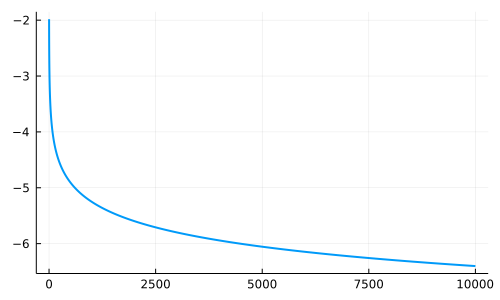

In [65]:
plot(1:epochs, vL, size=(500,300), linewidth=2, legend=false)

### Predict

In [66]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

ŷ = predictOutcome(X_d)
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 3882     0   103    46    30   161   112    66    51    72
    0  4536   225    94    90   229   136   213   351   112
   24    40  3239   142    30    48   134    55    81    32
   41    33   153  3652     3   882    12     9   600    87
    5     1    83     5  2948    73    41    40    26   163
   64    20     3    39     2  1957    75     1    83     7
   74     6   121    31    62    94  3613     3    27     4
    7     7    98    65    20    60     2  3787    43   290
   29    69   116   106    50    66    17    26  2567    44
   20     7    30   112   854   225     1   186   267  3353

accuracy: 0.798
f1-score: 0.793
